# Example usage of Met Office Deterministic STAC metadata

This notebook demonstrates how the STAC collection and item structure can be used to construct time series arrays using xarray, and how that is useful for downstream visualization and analysis.

In [1]:
import io
from collections import defaultdict
from datetime import datetime
from urllib.parse import urlparse

import imageio.v3 as iio
import matplotlib.pyplot as plt
import obstore as obs
import rustac
import xarray as xr
from obstore.store import from_url
from pyproj import CRS, Transformer
from pystac import Item
from tqdm.notebook import tqdm

from stactools.met_office_deterministic.stac import (
    create_collection,
    create_items_for_reference_time,
)

collection_ids = [
    "met-office-uk-deterministic-2km-surface",
    # "met-office-uk-deterministic-2km-height",
    # "met-office-uk-deterministic-2km-pressure",
]

Generate STAC collection objects

In [2]:
collections = {
    collection_id: create_collection(collection_id) for collection_id in collection_ids
}

Generate STAC items for all forecast runs for several days

In [3]:
items = []
for collection_id in tqdm(collection_ids):
    for day in tqdm(range(1, 5)):
        for hour in tqdm([0, 6, 12, 18]):
            reference_time = datetime(
                year=2025,
                month=9,
                day=day,
                hour=hour,
            )

            collection_items = create_items_for_reference_time(
                collection=collection_id,
                reference_time=reference_time,
            )
            for item in collection_items:
                item.collection_id = collection_id

            items.extend(collection_items)

print(f"created {len(items)} STAC items")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

created 3472 STAC items


Write to parquet so we can query it like an API with [rustac](https://stac-utils.github.io/rustac-py/latest/)

In [4]:
stac_items_parquet = "/tmp/items.parquet"

await rustac.write(stac_items_parquet, [item.to_dict() for item in items])

{'e_tag': '406f87-642568f86c620-c4247', 'version': None}

Search for items from a particular forecast run for the surface variables using a cql2-json filter to retrieve items associated with the forecast run for 2025-09-01T12:00:00.

In [5]:
surface_forecast_items = await rustac.search(
    stac_items_parquet,
    collections="met-office-uk-deterministic-2km-surface",
    filter={
        "op": "=",
        "args": [
            {"property": "forecast:reference_datetime"},
            "2025-09-01T12:00:00",
        ],
    },
)

print(len(surface_forecast_items))

217


In [6]:
sample_item = Item.from_dict(surface_forecast_items[0])
sample_item

<Item id=20250901T1200Z-20250901T1200Z>

Extract the variable-level asset URLs from the STAC items, then print the first url for each variable.

In [7]:
asset_urls = defaultdict(list)
for item in surface_forecast_items:
    for asset_key, asset in item["assets"].items():
        asset_urls[asset_key].append(asset["href"])

for asset_key, urls in asset_urls.items():
    print(asset_key, urls[0])

cloud_amount_below_1000ft_ASL s3://met-office-atmospheric-model-data/uk-deterministic-2km/20250901T1200Z/20250901T1200Z-PT0000H00M-cloud_amount_below_1000ft_ASL.nc
cloud_amount_of_high_cloud s3://met-office-atmospheric-model-data/uk-deterministic-2km/20250901T1200Z/20250901T1200Z-PT0000H00M-cloud_amount_of_high_cloud.nc
cloud_amount_of_low_cloud s3://met-office-atmospheric-model-data/uk-deterministic-2km/20250901T1200Z/20250901T1200Z-PT0000H00M-cloud_amount_of_low_cloud.nc
cloud_amount_of_medium_cloud s3://met-office-atmospheric-model-data/uk-deterministic-2km/20250901T1200Z/20250901T1200Z-PT0000H00M-cloud_amount_of_medium_cloud.nc
cloud_amount_of_total_cloud s3://met-office-atmospheric-model-data/uk-deterministic-2km/20250901T1200Z/20250901T1200Z-PT0000H00M-cloud_amount_of_total_cloud.nc
fog_fraction_at_screen_level s3://met-office-atmospheric-model-data/uk-deterministic-2km/20250901T1200Z/20250901T1200Z-PT0000H00M-fog_fraction_at_screen_level.nc
hail_fall_rate s3://met-office-atmosph

Configure an `obstore` storage instance using the collection's `storage:schemes` metadata so we can download the NetCDF files. This is not an optimal solution (it would be better to access the files directly in object storage) but downloading the files to disk is much more efficient than accessing them via `fsspec`.

In [8]:
storage_config = collections["met-office-uk-deterministic-2km-surface"].extra_fields[
    "storage:schemes"
]["aws"]
storage_config
store = from_url(
    storage_config["platform"].format(
        bucket=storage_config["bucket"],
        region=storage_config["region"],
    ),
    skip_signature=True,
)

Pick a pair of variables of interest then download the files and load them all into a set of 3D arrays (one array per variable).

In [9]:
variables_of_interest = [
    "wind_speed_at_10m",
    "temperature_at_surface",
]

local_files = defaultdict(list)


for variable in variables_of_interest:
    print(variable)
    for url in asset_urls[variable]:
        parsed = urlparse(url)
        resp = obs.get(store, parsed.path.strip("/"))

        local_file = f"/tmp/{parsed.path.split('/')[-1]}"

        with open(local_file, "wb") as f:
            for chunk in resp:
                f.write(chunk)

        local_files[variable].append(local_file)

wind_speed_at_10m
temperature_at_surface


In [10]:
datasets = {}

for variable, files in local_files.items():
    datasets[variable] = xr.open_mfdataset(
        files,
        chunks="auto",
        combine="nested",
        concat_dim="time",
        coords="different",
        compat="no_conflicts",
        parallel=True,
        decode_times=True,
        decode_timedelta=True,
    ).load()

In [11]:
datasets["temperature_at_surface"]

<xarray.Dataset> Size: 223MB
Dimensions:                       (time: 55, projection_y_coordinate: 970,
                                   projection_x_coordinate: 1042, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 440B 2025-09-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float32 4kB -1.03...
  * projection_x_coordinate       (projection_x_coordinate) float32 4kB -1.15...
    forecast_period               (time) timedelta64[ns] 440B 00:00:00 ... 2 ...
    forecast_reference_time       datetime64[ns] 8B 2025-09-01T12:00:00
Dimensions without coordinates: bnds
Data variables:
    surface_temperature           (time, projection_y_coordinate, projection_x_coordinate) float32 222MB ...
    lambert_azimuthal_equal_area  (time) int32 220B -2147483647 ... -2147483647
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float32 427kB ...
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float32 458kB ...
Attributes:
    history:                      2025-09-01T13:07:58Z: StaGE Decoupler
    institution:                  Met Office
    mosg__forecast_run_duration:  PT54H
    mosg__grid_domain:            uk_extended
    mosg__grid_type:              standard
    mosg__grid_version:           1.7.0
    mosg__model_configuration:    uk_det
    source:                       Met Office Unified Model
    title:                        UKV Model Forecast on UK 2 km Standard Grid
    um_version:                   13.1
    Conventions:                  CF-1.7, UKMO-1.0

Compute some quantiles to help set min/max for the color ramp in visualizations

In [12]:
da = datasets["temperature_at_surface"]["surface_temperature"]
da.quantile([0.05, 0.9, 0.99, 1]).compute()

<xarray.DataArray 'surface_temperature' (quantile: 4)> Size: 32B
array([285.   , 292.625, 297.25 , 311.625])
Coordinates:
  * quantile  (quantile) float64 32B 0.05 0.9 0.99 1.0

Render a GIF showing the forecasted surface temperature at each step in the forecast

In [13]:
vmin = 285
vmax = 312
images = []

for t in da.time.values:
    da.sel(time=t).plot.imshow(
        vmin=vmin,
        vmax=vmax,
        cmap="magma",
        figsize=(8, 6),
    )

    fig = plt.gcf()

    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)

    images.append(iio.imread(buf))

    plt.close(fig)


gif_filename = "surface_temperature.gif"
iio.imwrite(gif_filename, images, format="GIF", duration=100, loop=0)

![surface temperature animation](surface_temperature.gif)

Now do the same with the wind speed variable

In [14]:
da = datasets["wind_speed_at_10m"]["wind_speed"].load()
da.quantile([0.05, 0.9, 0.95, 1]).compute()

<xarray.DataArray 'wind_speed' (quantile: 4)> Size: 32B
array([ 1.875 , 12.375 , 13.9375, 23.4375])
Coordinates:
  * quantile  (quantile) float64 32B 0.05 0.9 0.95 1.0

In [15]:
vmin = 0
vmax = 15
images = []

for t in da.time.values:
    da.sel(time=t).plot.imshow(
        vmin=vmin,
        vmax=vmax,
        figsize=(8, 6),
    )

    fig = plt.gcf()

    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)

    images.append(iio.imread(buf))

    plt.close(fig)


gif_filename = "wind_speed.gif"
iio.imwrite(gif_filename, images, format="GIF", duration=100, loop=0)

![wind speed animation](wind_speed.gif)

Merge the two datasets into a single multi-variable dataset so we can easily extract values for geographic points.

In [23]:
ds_merged = xr.merge(datasets.values(), compat="no_conflicts")
ds_merged

<xarray.Dataset> Size: 446MB
Dimensions:                       (time: 55, projection_y_coordinate: 970,
                                   projection_x_coordinate: 1042, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 440B 2025-09-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float32 4kB -1.03...
  * projection_x_coordinate       (projection_x_coordinate) float32 4kB -1.15...
    forecast_period               (time) timedelta64[ns] 440B 00:00:00 ... 2 ...
    forecast_reference_time       datetime64[ns] 8B 2025-09-01T12:00:00
    height                        float32 4B 10.0
Dimensions without coordinates: bnds
Data variables:
    wind_speed                    (time, projection_y_coordinate, projection_x_coordinate) float32 222MB ...
    lambert_azimuthal_equal_area  (time) int32 220B -2147483647 ... -2147483647
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float32 427kB ...
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float32 458kB ...
    surface_temperature           (time, projection_y_coordinate, projection_x_coordinate) float32 222MB ...
Attributes:
    history:                      2025-09-01T13:07:06Z: StaGE Decoupler
    institution:                  Met Office
    mosg__forecast_run_duration:  PT54H
    mosg__grid_domain:            uk_extended
    mosg__grid_type:              standard
    mosg__grid_version:           1.7.0
    mosg__model_configuration:    uk_det
    source:                       Met Office Unified Model
    title:                        UKV Model Forecast on UK 2 km Standard Grid
    um_version:                   13.1
    Conventions:                  CF-1.7, UKMO-1.0

Extract the full time series of values for a single point

In [19]:
lat, lon = 51.439, -0.937

source_crs = CRS("EPSG:4326")
target_crs = CRS(sample_item.ext.proj.wkt2)

transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
x, y = transformer.transform(lon, lat)

In [20]:
point_forecasts = ds_merged[["wind_speed", "surface_temperature"]].sel(
    projection_x_coordinate=x,
    projection_y_coordinate=y,
    method="nearest",
)
point_forecasts

<xarray.Dataset> Size: 1kB
Dimensions:                  (time: 55)
Coordinates:
  * time                     (time) datetime64[ns] 440B 2025-09-01T12:00:00 ....
    projection_y_coordinate  float32 4B -3.84e+05
    projection_x_coordinate  float32 4B 1.08e+05
    forecast_period          (time) timedelta64[ns] 440B 00:00:00 ... 2 days ...
    forecast_reference_time  datetime64[ns] 8B 2025-09-01T12:00:00
    height                   float32 4B 10.0
Data variables:
    wind_speed               (time) float32 220B 6.062 4.688 ... 9.688 8.875
    surface_temperature      (time) float32 220B 292.8 291.6 ... 292.5 291.2
Attributes:
    history:                      2025-09-01T13:07:06Z: StaGE Decoupler
    institution:                  Met Office
    mosg__forecast_run_duration:  PT54H
    mosg__grid_domain:            uk_extended
    mosg__grid_type:              standard
    mosg__grid_version:           1.7.0
    mosg__model_configuration:    uk_det
    source:                       Met Office Unified Model
    title:                        UKV Model Forecast on UK 2 km Standard Grid
    um_version:                   13.1
    Conventions:                  CF-1.7, UKMO-1.0

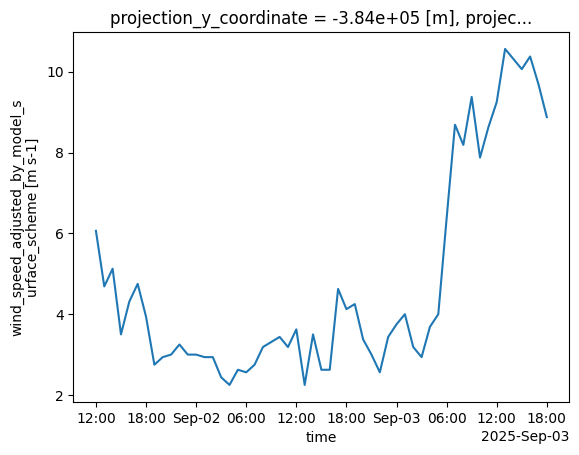

In [21]:
point_forecasts["wind_speed"].plot.line()

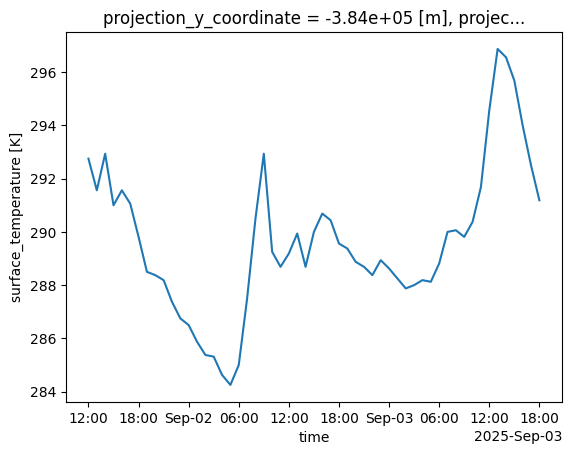

In [22]:
point_forecasts["surface_temperature"].plot.line()